In [1]:
from amptools import process
import os
import numpy as np
from obspy import read
from obspy import Stream
from obspy import UTCDateTime
from obspy.signal.util import next_pow_2
import matplotlib.pyplot as plt
import warnings

size=(1000, 500)
os.chdir('../tests/data/process')
warnings.filterwarnings('ignore')

Missing config file /Users/jrekoske/.amptools/config.yml, setting config to default config.


# Processing Workflow

![title](Processing Flow.png)

## Load in data

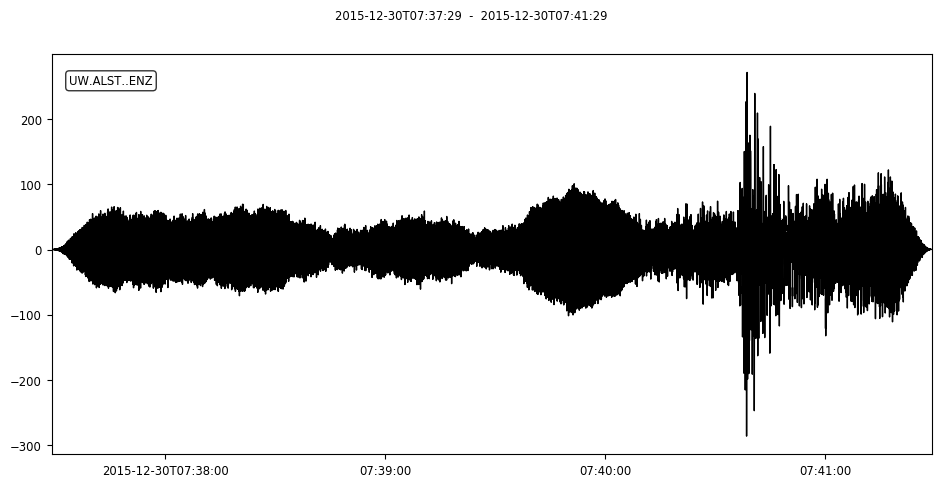

In [2]:
ALST_st = read('ALSTENZ.sac')
ALST_tr = ALST_st[0]
org_time = UTCDateTime('2015-12-30T07:39:29')
ALST_tr.plot(size=size)

## Check Amplitude

In [3]:
process.check_max_amplitude(ALST_tr)

True

## Trim

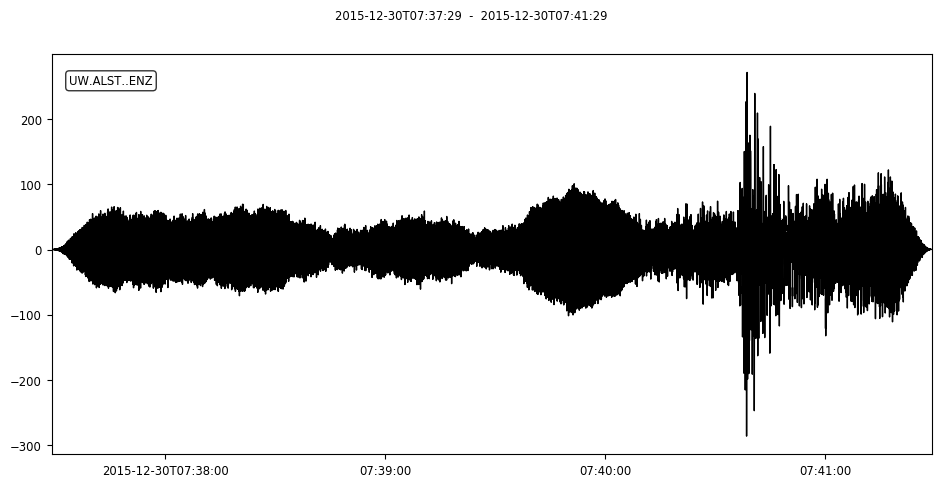

In [4]:
ALST_tr_trim = process.trim_total_window(ALST_tr, org_time, ALST_tr.stats.sac.dist)
ALST_tr_trim.plot(size=size)

## Split signal and noise

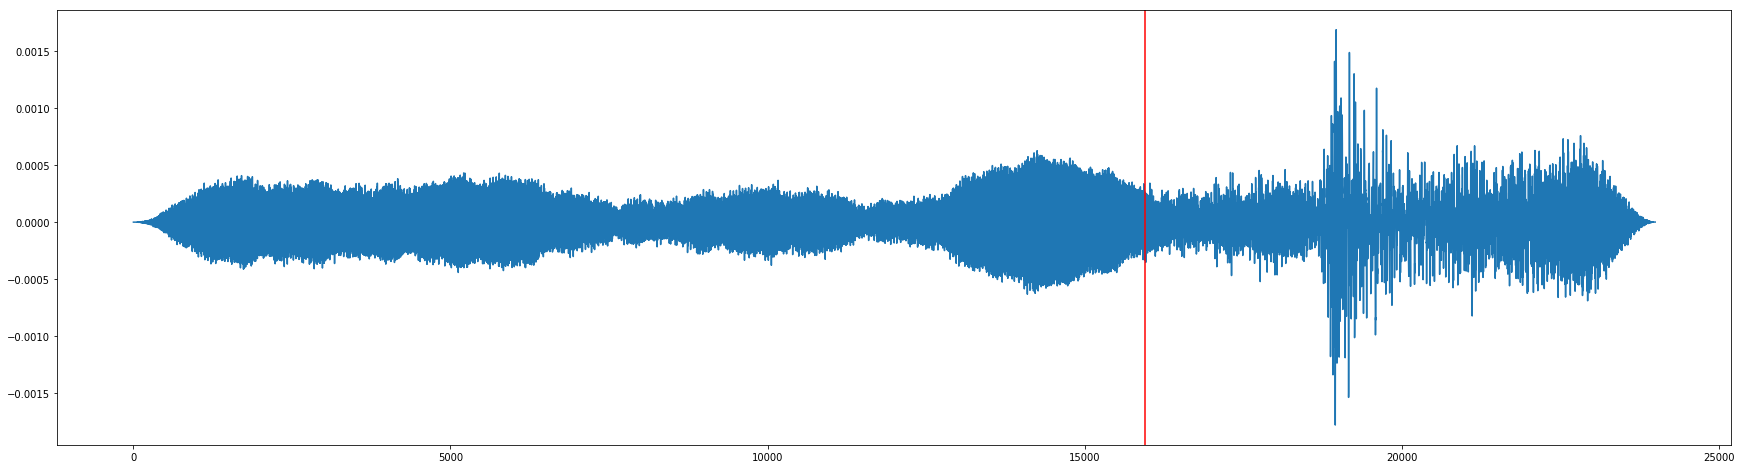

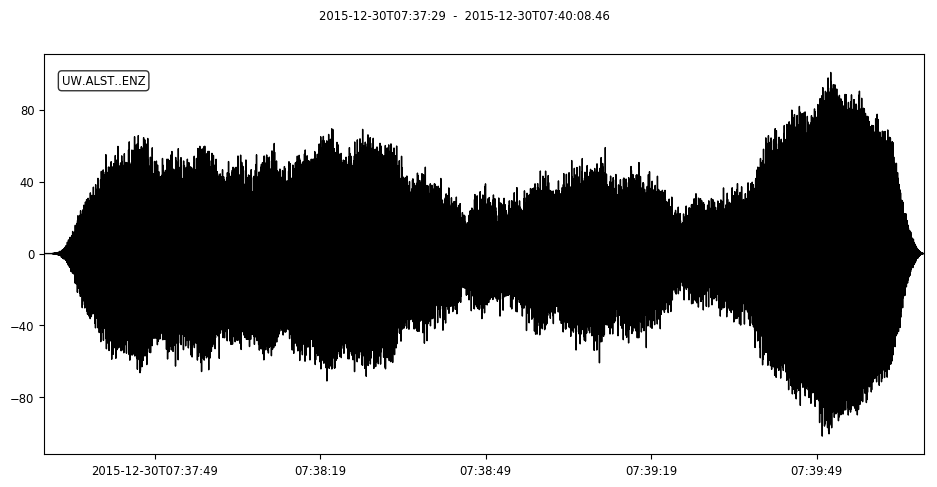

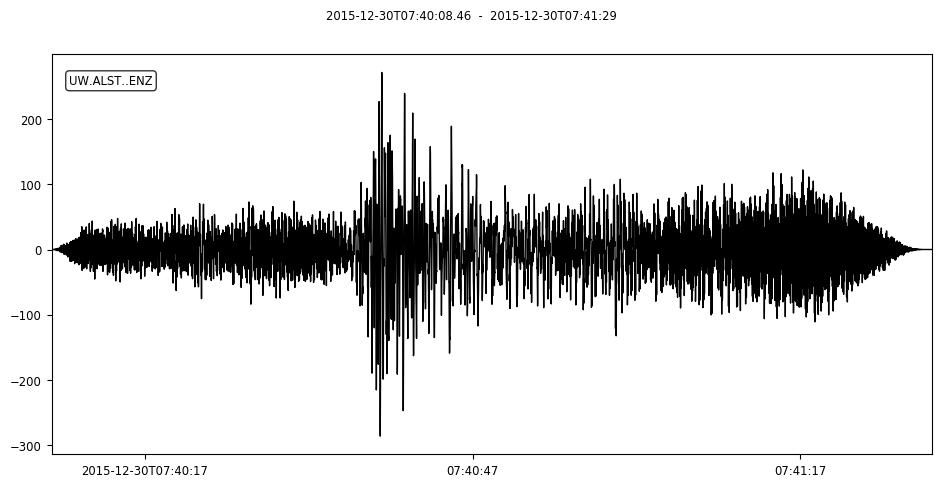

In [5]:
signal, noise = process.split_signal_and_noise(ALST_tr_trim, org_time, ALST_tr.stats.sac.dist)
plt.figure(figsize=(30,8))
plt.plot(ALST_tr_trim.data)
plt.axvline(x=(noise.stats.endtime-ALST_tr_trim.stats.starttime) / ALST_tr_trim.stats.delta, color='red')
plt.plot()

noise = process.taper(noise, taper_type='hann',
                  max_percentage=0.05, side='both')
signal = process.taper(signal, taper_type='hann',
                   max_percentage=0.05, side='both')

noise.plot(size=size)
signal.plot(size=size)

## Find corner frequencies

[0.439453125, 11.395263671875]


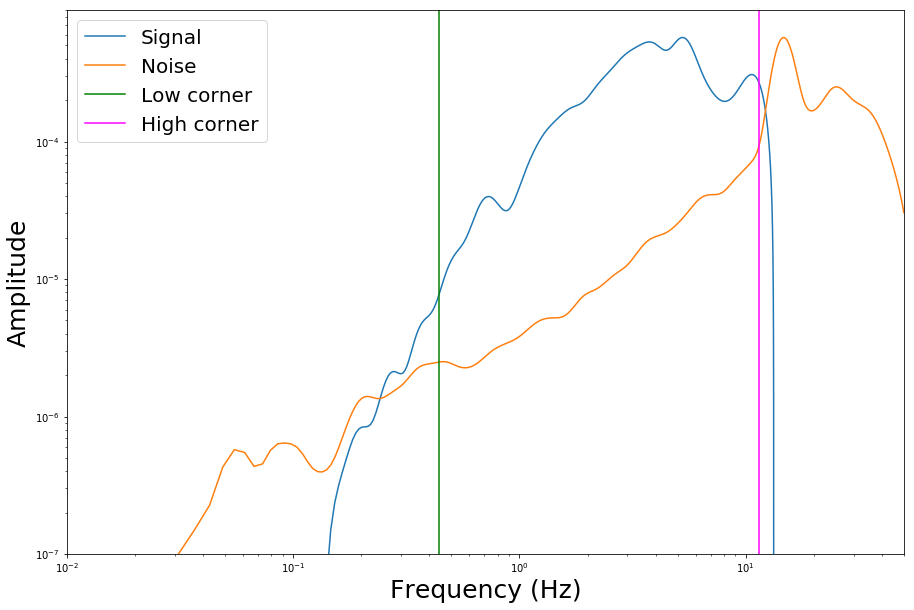

In [6]:
nfft = max(next_pow_2(signal.stats.npts), next_pow_2(noise.stats.npts))
signal_spectrum, signal_freqs = process.fft_smooth(signal, nfft)
noise_spectrum, noise_freqs = process.fft_smooth(noise, nfft)

signal_spectrum -= noise_spectrum
corners = process.get_corner_frequencies(ALST_tr_trim, org_time, ALST_tr_trim.stats.sac.dist, max_low_corner=0.5, min_high_corner=5.0)
print(corners)

plt.figure(figsize=(15,10))
plt.plot(signal_freqs, signal_spectrum, label='Signal')
plt.plot(noise_freqs, noise_spectrum, label='Noise')
plt.axvline(x=corners[0], label='Low corner', color='green')
plt.axvline(x=corners[1], label='High corner', color='magenta')
plt.xlabel('Frequency (Hz)', fontsize=25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin=0.01, xmax=50)
plt.ylim(ymin=0.0000001, ymax=0.0009)
plt.ylabel('Amplitude', fontsize=25)
plt.legend(fontsize=20)
plt.show()


##  Filter the waveform

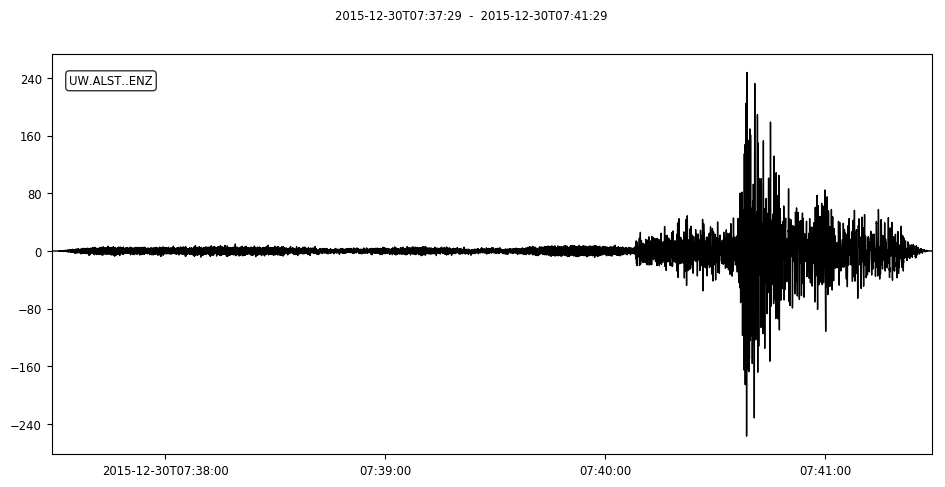

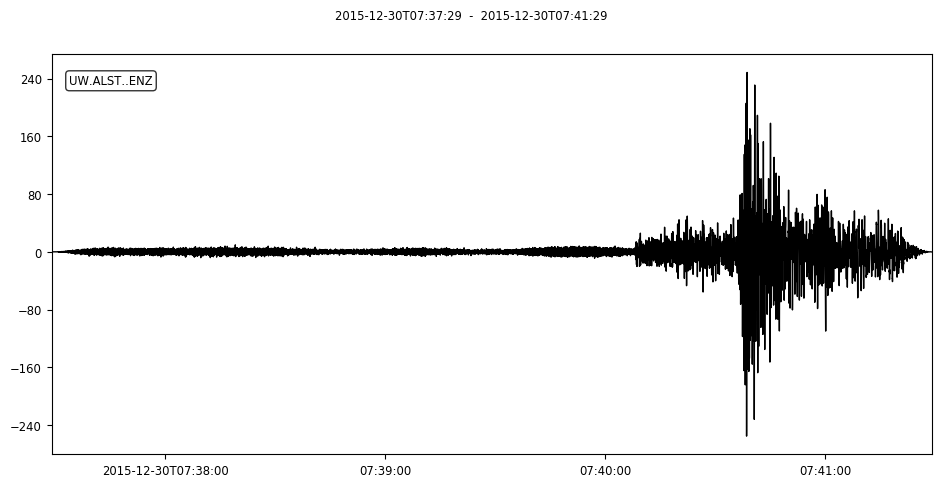

In [7]:
process.filter_waveform(ALST_tr_trim, 'lowpass', zerophase=True, corners=5, freqmax=corners[1])
ALST_tr_trim.plot(size=size)

before_high = ALST_tr_trim.data

process.filter_waveform(ALST_tr_trim, 'highpass', zerophase=True, corners=5, freqmin=corners[0])
ALST_tr_trim.plot(size=size)

## Polynomial baseline correction

          6             5             4            3             2
8.72e-31 x - 6.439e-26 x + 1.803e-21 x - 2.36e-17 x + 1.416e-13 x


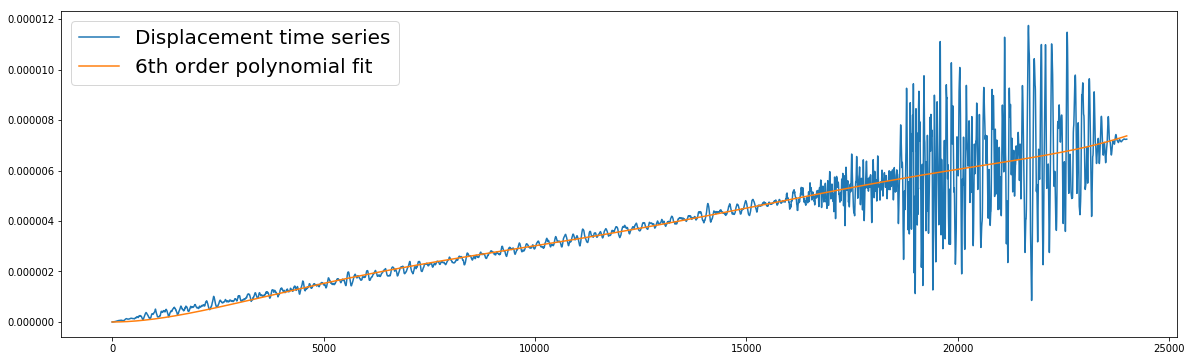

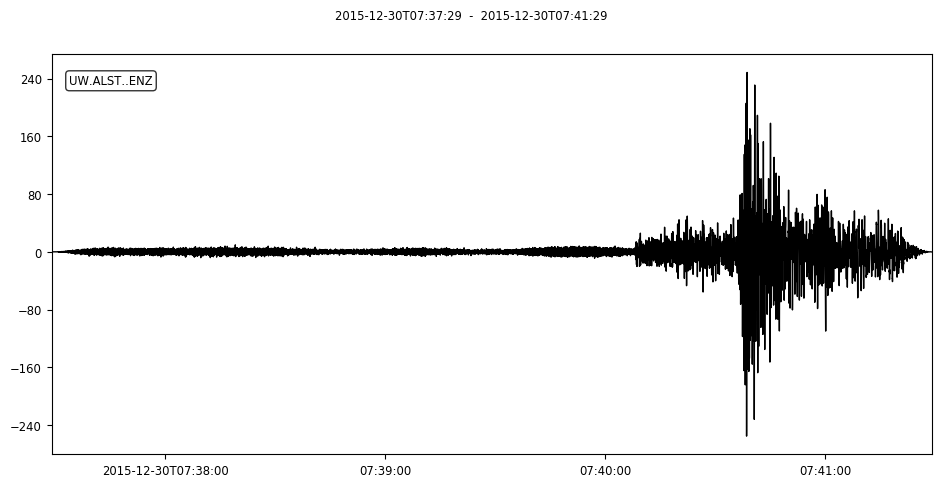

In [8]:
import numpy as np
from scipy.optimize import curve_fit

def poly_func(x, a, b, c, d, e):
        """
        Model polynomial function for polynomial baseline correction.
        """
        return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2

def correct_baseline_and_plot(trace):
    """
    Performs a baseline correction following the method of Ancheta
    et al. (2013). This removes low-frequency, non-physical trends
    that remain in the time series following filtering.

    Args:
        trace (obspy.core.trace.Trace): Trace of strong motion data.

    Returns:
        trace (obspy.core.trace.Trace): Baseline-corrected trace.
    """

    # Make copies of the trace for our accleration data
    orig_trace = trace.copy()
    acc_trace = trace.copy()

    # Integrate twice to get the displacement time series
    disp_trace = (acc_trace.integrate()).integrate()

    # Fit a sixth order polynomial to displacement time series, requiring
    # that the 1st and 0th order coefficients are zero
    time_values = np.linspace(0, trace.stats.npts-1, trace.stats.npts)
    poly_cofs = list(curve_fit(poly_func, time_values, disp_trace.data)[0])
    poly_cofs += [0, 0]

    # Construct a polynomial from the coefficients and compute
    # the second derivative
    polynomial = np.poly1d(poly_cofs)
    print(polynomial)

    plt.figure(figsize=(20,6))
    plt.plot(disp_trace.data, label='Displacement time series')
    plt.plot(polynomial(time_values), label='6th order polynomial fit')
    plt.legend(fontsize=20)
    plt.plot()

    polynomial_second_derivative = np.polyder(polynomial, 2)

    # Subtract the second derivative of the polynomial from the
    # acceleration trace
    for i in range(orig_trace.stats.npts):
        orig_trace.data[i] -= polynomial_second_derivative(i)
    return orig_trace

ALST_tr_cor = correct_baseline_and_plot(ALST_tr_trim)
ALST_tr_cor.plot(size=size)

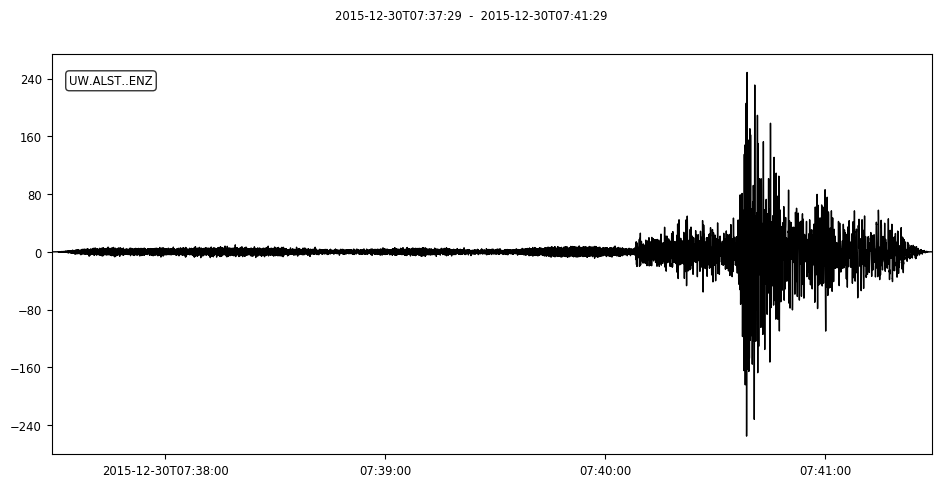

AttribDict({'amplitude': AttribDict({'min': 1e-08, 'max': 10.0}), 'baseline_correct': True, 'taper': AttribDict({'max_percentage': 0.05, 'type': 'hann', 'side': 'both'}), 'window': AttribDict({'vmin': 1.0}), 'filters': [[[{'type': 'highpass', 'zerophase': True, 'corners': 5}], {'type': 'lowpass', 'zerophase': True, 'corners': 5}]], 'corners': AttribDict({'default_high_frequency': 20.0, 'default_low_frequency': 0.1, 'min_high_freq': 10.0, 'sn_ratio': 3.0, 'get_dynamically': True, 'max_low_freq': 0.5, 'high_corner': 11.395263671875, 'low_corner': 0.439453125})})
True


In [9]:
# Processing from a configuration
my_config = {
        'processing_parameters': {
                'amplitude': {
                        'min': 10e-9,
                        'max': 10.0
                },
                'window': {
                        'vmin': 1.0
                },
                'taper': {
                        'type': 'hann',
                        'max_percentage': 0.05,
                        'side': 'both'
                },
                'corners': {
                        'get_dynamically': True,
                        'sn_ratio': 3.0,
                        'max_low_freq': 0.5,
                        'min_high_freq': 10.0,
                        'default_low_frequency': 0.1,
                        'default_high_frequency': 20.0
                },
                'filters': [{
                        'type': 'highpass',
                        'corners': 5,
                        'zerophase': True
                },{
                        'type': 'lowpass',
                        'corners': 5,
                        'zerophase': True
                }],
                'baseline_correct': True,
        }
}

ALST_st = read('ALSTENZ.sac')
ALST_tr = ALST_st[0]
ALST_cor = process.process_config(ALST_st, my_config, org_time, ALST_tr.stats.sac.dist)
ALST_cor.plot(size=size)

print(ALST_cor[0].stats['processing_parameters'])
print(ALST_cor[0].stats['passed_tests'])

## Test Failure Example

In [10]:
ALST_st = read('ALSTENZ.sac')
ALST_tr_mul = ALST_st[0]
ALST_tr_mul.data *= 10000000
ALST_st_mul = Stream(ALST_tr_mul)
ALST_mul_proc = process.process_config(ALST_st_mul, my_config, org_time, ALST_tr.stats.sac.dist)
print(ALST_mul_proc[0].stats['passed_tests'])
print(ALST_mul_proc[0].stats['standard']['comments'])

False
Processing: Trace maximum amplitude is not within the acceptable range: 1e-08 to 10.0. Skipping processing for trace: <obspy.core.trace.Trace object at 0x11b68d588>
